# Colab Edition

**What this is**  
A Google Colab–oriented notebook that **combines Notebook 02 (Pre-processing)** and **Notebook 03 (Model Training & Evaluation)** into one place. Only minor changes were made to make it Colab-friendly.

**What changed (lightly):**
- Path handling that works on Colab (optional Google Drive mount + safe `DATA_DIR/RESULTS_DIR` defaults).
- Silent install of `python-chess` if missing.
- Small housekeeping for deterministic seeds and progress printing.
- No logic changes to the core pipeline or model.

**How to use (Colab):**
1. *(Optional)* Mount Google Drive and set `DATA_DIR` to your project folder.  
2. Run the cells top-to-bottom:
   - **A. Pre-processing**: load raw CSV -> tokenize SAN -> keep first 60 plies -> add light features (captures/checks [+ optional Elo]) -> save clean CSV & meta.
   - **B. Training & Evaluation**: build splits & vocab -> create `tf.data` -> train BiGRU model -> tune threshold on **val** -> evaluate on test
3. Outputs are written to `results/`.

**Expected inputs**
- `data/chess_games_subset.csv` (moves in SAN/AN + result).  
  You can point `DATA_DIR` to a different location if needed.

**Saved artifacts (in `results/`):**
- `best_seq_model.keras`, `seq_report.json`, `label_mapping.json`, `class_weights.json` *(if used)*, `vocab.json`, `dl_config.json`.

> Tip: If running from Drive, keep your folder layout as in the repo (`data/`, `results/`) to avoid path edits.

In [ ]:
# === Colab setup: mount Drive + robust project paths ===
from pathlib import Path
import sys, os

# 1) Mount Google Drive if running on Colab
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

# 2) Point to your project folder name in Drive
REPO_NAME = "chess-outcome-prediction"  # <-- change if your folder name differs

def find_project_root():
    """Find the project root that contains 'data' and 'notebooks'."""
    # Common places in Drive
    candidates = [
        Path("/content/drive/MyDrive") / REPO_NAME,
        Path("/content/drive/MyDrive/Colab Notebooks") / REPO_NAME,
        Path.cwd(),  # in case notebook is opened inside the repo already
    ]
    for p in candidates:
        if (p / "data").exists() and (p / "notebooks").exists():
            return p.resolve()

    shared_root = Path("/content/drive/Shareddrives")
    if shared_root.exists():
        for d in shared_root.iterdir():
            if d.is_dir():
                candidates.append(d / repo_name)

    # Walk up from current dir as a fallback
    here = Path.cwd().resolve()
    for parent in [here, *here.parents]:
        if (parent / "data").exists() and (parent / "notebooks").exists():
            return parent.resolve()

    raise FileNotFoundError(
        "Could not locate the project root. "
        "Set REPO_NAME correctly or move this notebook inside the repo."
    )

PROJ_DIR = find_project_root()

# 3) Define standard paths (used by your notebooks)
NB_DIR      = Path.cwd()
DATA_DIR    = PROJ_DIR / "data"
RESULTS_DIR = PROJ_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 4) File paths used across notebooks
RAW_SUBSET  = DATA_DIR / "chess_games_subset.csv"
CLEAN_CSV   = DATA_DIR / "chess_games_clean.csv"
META_JSON   = DATA_DIR / "chess_games_clean_meta.json"
BOARDS_NPZ  = DATA_DIR / "chess_boards_8x8xC.npz"

print("Project dir :", PROJ_DIR)
print("Data dir    :", DATA_DIR)
print("Results dir :", RESULTS_DIR)
print("RAW_SUBSET exists? ", RAW_SUBSET.exists())

# Optional: fail early with a clear message if files are missing
assert RAW_SUBSET.exists(), (
    f"Missing {RAW_SUBSET}. Place your CSVs in: {DATA_DIR}"
)

Mounted at /content/drive
Project dir : /content/drive/MyDrive/chess-outcome-prediction
Data dir    : /content/drive/MyDrive/chess-outcome-prediction/data
Results dir : /content/drive/MyDrive/chess-outcome-prediction/results
RAW_SUBSET exists?  True


In [ ]:
# @title 🔧 Colab GPU setup (run once, before training)
# This cell configures TensorFlow to use the Colab GPU efficiently.
# If no GPU is found, you'll see a hint to enable it in Runtime → Change runtime type → GPU.

import os, tensorflow as tf

# Optional toggles (editable in Colab UI)
USE_MIXED_PRECISION = True  # @param {type:"boolean"}
USE_XLA             = True  # @param {type:"boolean"}
LIMIT_GPU_MEM_GROWTH = True # @param {type:"boolean"}

print(f"TensorFlow: {tf.__version__}")

# 1) Detect GPU
gpus = tf.config.list_physical_devices("GPU")
if not gpus:
    print(
        "No GPU detected. In Colab: Runtime → Change runtime type → Hardware accelerator → GPU, then rerun."
    )
else:
    print(f"GPU(s) found: {[g.name for g in gpus]}")

    # 2) Safer memory handling
    if LIMIT_GPU_MEM_GROWTH:
        try:
            for g in gpus:
                tf.config.experimental.set_memory_growth(g, True)
            print("Enabled memory growth on GPU(s).")
        except Exception as e:
            print("Memory growth setup warning:", e)

    # 3) Optional speed-ups
    if USE_XLA:
        try:
            tf.config.optimizer.set_jit(True)  # enable XLA
            print("Enabled XLA (JIT compilation).")
        except Exception as e:
            print("XLA setup warning:", e)

    # Enable TF32 on Ampere+ (speeds up matmul/conv with tiny precision tradeoff)
    try:
        tf.config.experimental.enable_tensor_float_32_execution(True)
        print("Enabled TF32 execution where supported.")
    except Exception as e:
        pass

    # 4) Mixed precision (recommended on recent GPUs)
    if USE_MIXED_PRECISION:
        try:
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy("mixed_float16")
            # Tip: keep the final output layer in float32 or rely on Keras automatic casting.
            print(f"Mixed precision policy: {mixed_precision.global_policy()}")
        except Exception as e:
            print("Mixed precision setup warning:", e)

    # 5) Show the logical devices we’ll use
    print("Devices in use:", tf.config.list_logical_devices())

print("GPU setup complete. Proceed to training")

TensorFlow: 2.19.0
✅ GPU(s) found: ['/physical_device:GPU:0']
🧠 Enabled memory growth on GPU(s).
⚡ Enabled XLA (JIT compilation).
🔢 Enabled TF32 execution where supported.
🧪 Mixed precision policy: <DTypePolicy "mixed_float16">
Devices in use: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU setup complete. Proceed to training ✅


# CHESS OUTCOME PREDICTION - PRE-PROCESSING

**Goal**: build a clean sequence-only dataset (plus optional 8×8×C board tensors) for model training.  
**Cut-off**: first 30 full moves (60 plies).

**I/O**
- **Input**: `data/chess_games_subset.csv` (SAN/AN moves, `Result`, Elo, etc.)
- **Outputs**:
  - `data/chess_games_clean.csv`
  - `data/chess_games_clean_meta.json`
  - *(optional)* `data/chess_boards_8x8xC.npz` (board planes)

**Pipeline (overview)**
1. Load subset -> normalize labels to `{white, black, draw}`.
2. Tokenize SAN/AN; strip move numbers/results -> keep first 60 plies.
3. Add features: `plies_processed`, `cutoff_reached`, `captures_in_first_30_moves`, `checks_in_first_30_moves`.
4. Elo features: compute `elo_diff = white_elo - black_elo`, `elo_avg`.
5. Leakage guard: drop raw winner/result/Elo columns from features.
6. Impute & downcast numerics.
7. *(Optional)* Export 8×8×C board planes at plies `[20, 40, 60]`.
8. Sanity checks (class balance, NAs, sequence length) -> save CSV & meta.


In [ ]:
# ==============================================
# 1. Imports & Paths
# ==============================================
from pathlib import Path
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

# ----------------------------------------------
# 1.1 Ensure python-chess
# ----------------------------------------------
try:
    import chess
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-chess", "--quiet"])
    import chess
print("python-chess OK.")

# ----------------------------------------------
# 1.2 Config (sequence only)
# ----------------------------------------------
CUTOFF_FULL_MOVES = 30
CUTOFF_PLIES = CUTOFF_FULL_MOVES * 2
MOVE_COL = f"moves_first{CUTOFF_FULL_MOVES}_san"
CAPTURES_COL = f"captures_in_first_{CUTOFF_FULL_MOVES}_moves"
CHECKS_COL = f"checks_in_first_{CUTOFF_FULL_MOVES}_moves"
SEQUENCE_ONLY = True
INCLUDE_ELO   = True

CHECKPOINT_PLIES = [20, 40, 60]
BOARDS_NPZ = DATA_DIR / "chess_boards_8x8xC.npz"

print("Data dir:", DATA_DIR)
print("Input :", RAW_SUBSET)
print("Output:", CLEAN_CSV)
print(f"Cutoff: {CUTOFF_FULL_MOVES} moves ({CUTOFF_PLIES} plies)")

python-chess OK.
Data dir: /content/drive/MyDrive/chess-outcome-prediction/data
Input : /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_subset.csv
Output: /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_clean.csv
Cutoff: 30 moves (60 plies)


In [ ]:
# ==============================================
# 2. Load Subset
# ==============================================
df_raw = pd.read_csv(RAW_SUBSET)

# ----------------------------------------------
# 2.1 Detect Columns
# ----------------------------------------------
cols = {c.lower(): c for c in df_raw.columns}

an_col = None
for k in ["an", "moves", "algebraic", "algebraicnotation"]:
    if k in cols:
        an_col = cols[k]
        break
if an_col is None:
    raise ValueError("Moves column (AN) not found. Expected a column like 'AN' or 'Moves'.")

label_col = None
for k in ["result", "target", "winner", "outcome"]:
    if k in cols:
        label_col = cols[k]
        break
if label_col is None:
    raise ValueError("Label column not found. Expected 'Result' or similar.")

# ----------------------------------------------
# 2.2 Clean Labels
# ----------------------------------------------
def map_label(v):
    s = str(v).strip().lower()
    if s in {"1-0", "white", "w"}:
        return "white"
    if s in {"0-1", "black", "b"}:
        return "black"
    if s in {"1/2-1/2", "draw", "d"}:
        return "draw"
    return np.nan

df = pd.DataFrame(
    {
        "moves_raw": df_raw[an_col].astype(str),
        "target": df_raw[label_col].map(map_label),
    }
).dropna(subset=["moves_raw", "target"]).reset_index(drop=True)

print(df.shape)
df.head(3)

(142303, 2)


,moves_raw,target
0,1. f4 d5 2. g3 c5 3. Bg2 Nc6 4. Nf3 Bf5 5. O-O...,white
1,1. e4 b6 2. d4 Bb7 3. Bd3 e6 4. f4 d6 5. Nf3 h...,white
2,1. d4 Nf6 2. c4 e6 3. Nc3 c5 4. d5 d6 5. e3 e5...,black


In [ ]:
# ==============================================
# 3. Extract First 30 Moves (60 plies)
# ==============================================

# ----------------------------------------------
# 3.1 Helpers
# ----------------------------------------------
RESULT_TOKENS = {"1-0", "0-1", "1/2-1/2"}

def tokenize_an(s: str):
    toks = str(s).replace("\r", " ").replace("\n", " ").split()
    keep = []
    for t in toks:
        if t.endswith(".") and t[:-1].isdigit():
            continue
        if t == "...":
            continue
        if t in RESULT_TOKENS:
            continue
        keep.append(t)
    return keep

def count_captures(seq):
    return sum("x" in m for m in seq)

def count_checks(seq):
    return sum(("+" in m) or ("#" in m) for m in seq)

# --- Board helpers (append) ---
def _board_planes(b):
    # 12 planes: white/black {P,N,B,R,Q,K} -> (8,8,12) uint8
    planes = []
    for color, pieces in [(chess.WHITE, [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]),
                          (chess.BLACK, [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING])]:
        for p in pieces:
            plane = np.zeros((8, 8), dtype=np.uint8)
            for sq in b.pieces(p, color):
                r = 7 - (sq // 8); c = sq % 8
                plane[r, c] = 1
            planes.append(plane)
    return np.stack(planes, axis=-1)  # (8,8,12)

def boards_from_san_list(san_list, checkpoints=CHECKPOINT_PLIES):
    b = chess.Board()
    out = []
    want = list(checkpoints)
    ply = 0
    for m in san_list:
        try:
            b.push_san(m)
        except Exception:
            break
        ply += 1
        while want and ply >= want[0]:
            out.append(_board_planes(b))
            want.pop(0)
    while want:  # pad with empty boards if short
        out.append(np.zeros((8, 8, 12), dtype=np.uint8))
        want.pop(0)
    return np.concatenate(out, axis=-1)  # (8,8, 12*len(checkpoints))

# ----------------------------------------------
# 3.2 Build Sequence Columns
# ----------------------------------------------
tokens = df["moves_raw"].apply(tokenize_an)
tokens_cut = tokens.apply(lambda t: t[:CUTOFF_PLIES])

df[MOVE_COL] = tokens_cut.apply(lambda t: " ".join(t))
df["plies_processed"] = tokens_cut.apply(len)
df["cutoff_reached"] = (df["plies_processed"] == CUTOFF_PLIES).astype(int)
df[CAPTURES_COL] = tokens_cut.apply(count_captures)
df[CHECKS_COL] = tokens_cut.apply(count_checks)

df = df.dropna(subset=[MOVE_COL, "target"]).reset_index(drop=True)

print(df.shape)
df[[MOVE_COL, "plies_processed", "target"]].head(3)

(142303, 7)


,moves_first30_san,plies_processed,target
0,f4 d5 g3 c5 Bg2 Nc6 Nf3 Bf5 O-O e6 d3 g6 Be3 h...,33,white
1,e4 b6 d4 Bb7 Bd3 e6 f4 d6 Nf3 h6 O-O a6 Qe2 Ne...,28,white
2,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,60,black


In [ ]:
# ==============================================
# 4. Assemble Working Frame (sequence-only, no leakage)
# ==============================================

# ----------------------------------------------
# 4.1 Select Columns
# ----------------------------------------------
keep_cols = [MOVE_COL, "plies_processed", "cutoff_reached", CAPTURES_COL, CHECKS_COL, "target"]
missing = [c for c in keep_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

X = df[keep_cols].copy()

# ----------------------------------------------
# 4.2 Leakage Guard
# ----------------------------------------------
banned = {
    "Result","result","winner","Winner","termination","Termination",
    "num_moves","NumMoves","Opening","opening","ECO","eco","Moves","AN",
    "UTCDate","UTCTime","Event","TimeControl","White","Black",
    "WhiteElo","BlackElo","white_elo","black_elo",
    "WhiteRating","BlackRating","WhiteRatingDiff","BlackRatingDiff"
}
present_banned = [c for c in X.columns if c in banned]
assert not present_banned, f"Leaky columns present in X: {present_banned}"

# ----------------------------------------------
# 4.3 Types
# ----------------------------------------------
X[MOVE_COL] = X[MOVE_COL].fillna("").astype(str)
X["target"] = X["target"].astype(str)
for c in ["plies_processed", "cutoff_reached", CAPTURES_COL, CHECKS_COL]:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# ----------------------------------------------
# 4.4 Elo Features (pre-game, derived only; read from df_raw)
# ----------------------------------------------
# robust selection (case-insensitive; supports Elo or Rating; ignores *Diff)
lower_map = {c.lower(): c for c in df_raw.columns}

def pick_rating(side: str):
    side_l = side.lower()
    prefs = [
        f"{side_l}elo", f"{side_l}_elo",
        f"{side_l}rating", f"{side_l}_rating",
    ]
    for p in prefs:
        if p in lower_map:
            return lower_map[p]
    cands = [c for c in df_raw.columns
             if (side_l in c.lower()) and (("elo" in c.lower()) or ("rating" in c.lower()))]
    return cands[0] if cands else None

w_col = pick_rating("White")
b_col = pick_rating("Black")

if w_col and b_col:
    # Explicit, side-aware columns kept in the CLEAN set
    X["white_elo"] = pd.to_numeric(df_raw[w_col], errors="coerce")
    X["black_elo"] = pd.to_numeric(df_raw[b_col], errors="coerce")

    # Directional diff (white - black) and average derived from the above
    X["elo_diff"] = (X["white_elo"] - X["black_elo"])
    X["elo_avg"]  = (X["white_elo"] + X["black_elo"]) / 2.0

    # Coerce types (plays nicely with your Section 5 downcast)
    X["elo_diff"] = pd.to_numeric(X["elo_diff"], errors="coerce")
    X["elo_avg"]  = pd.to_numeric(X["elo_avg"],  errors="coerce")

    print(f"Elo detected → White: '{w_col}', Black: '{b_col}'. "
          f"Added white_elo/black_elo + elo_diff/elo_avg.")
else:
    print("No Elo columns detected in df_raw; skipping Elo features.")

# ----------------------------------------------
# 4.5 Filter: require the game to reach the cutoff
# ----------------------------------------------
REQUIRE_CUTOFF = True  # set False if you want to keep everything

if REQUIRE_CUTOFF:
    before = len(X)
    X = X[X["plies_processed"] >= CUTOFF_PLIES].reset_index(drop=True)
    kept = len(X)
    print(f"Kept games reaching {CUTOFF_PLIES} plies: {kept}/{before} ({kept/before:.1%})")
else:
    print("Not filtering by cutoff (short games included).")

# ----------------------------------------------
# 4.6 Binary Task (drop draws)
# ----------------------------------------------

BINARY_TASK = True

if BINARY_TASK:
    before = len(X)
    X = X[X["target"].isin(["white", "black"])].reset_index(drop=True)
    kept = len(X)
    print(f"Kept non-draws: {kept}/{before} ({kept/before:.1%})")
else:
    print("Keeping draws (3-class task).")

Elo detected → White: 'WhiteElo', Black: 'BlackElo'. Added white_elo/black_elo + elo_diff/elo_avg.
Kept games reaching 60 plies: 89061/142303 (62.6%)
Kept non-draws: 83944/89061 (94.3%)


In [ ]:
# ==============================================
# 5. Impute & Downcast (sequence-only)
# ==============================================
import numpy as np

def mem_mb(df):
    return df.memory_usage(deep=True).sum() / (1024**2)

print(f"Memory before: {mem_mb(X):.2f} MB")

# ----------------------------------------------
# 5.1 Impute Numerics
# ----------------------------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for c in num_cols:
    med = X[c].median()
    X[c] = X[c].fillna(med)

# ----------------------------------------------
# 5.2 Downcast Numerics
# ----------------------------------------------
for c in num_cols:
    if pd.api.types.is_integer_dtype(X[c]):
        X[c] = pd.to_numeric(X[c], downcast="integer")
    elif pd.api.types.is_float_dtype(X[c]):
        X[c] = pd.to_numeric(X[c], downcast="float")

# ----------------------------------------------
# 5.3 Preserve Sequence & Target Types
# ----------------------------------------------
X[MOVE_COL] = X[MOVE_COL].fillna("").astype(str)
X["target"] = X["target"].astype(str)

print(f"Memory after: {mem_mb(X):.2f} MB")
display(X.dtypes.to_frame("dtype").T)
display(X.head(3))

Memory before: 33.19 MB
Memory after: 29.19 MB


,moves_first30_san,plies_processed,cutoff_reached,captures_in_first_30_moves,checks_in_first_30_moves,target,white_elo,black_elo,elo_diff,elo_avg
dtype,object,int8,int8,int8,int8,object,int16,int16,int16,float32


,moves_first30_san,plies_processed,cutoff_reached,captures_in_first_30_moves,checks_in_first_30_moves,target,white_elo,black_elo,elo_diff,elo_avg
0,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,60,1,13,3,black,2193,1782,411,1987.5
1,e4 e5 Nf3 Nc6 d4 Nxd4 Nxe5 Qe7 f4 d6 Qxd4 dxe5...,60,1,17,3,black,1548,1632,-84,1590.0
2,d4 d5 c4 Nf6 Nc3 c6 Bg5 e6 Nf3 Be7 e3 O-O c5 h...,60,1,12,2,black,1604,1918,-314,1761.0


In [ ]:
# ==============================================
# 6. Sanity Checks (leakage / balance / NAs / sequence)
# ==============================================

# ----------------------------------------------
# 6.1 Leakage Guard
# ----------------------------------------------
banned = {
    "Result","result","winner","Winner","termination","Termination",
    "num_moves","NumMoves","Opening","opening","ECO","eco","Moves","AN",
    "UTCDate","UTCTime","Event","TimeControl","White","Black",
    "WhiteElo","BlackElo","WhiteRatingDiff","BlackRatingDiff"
}
present_banned = [c for c in X.columns if c in banned]
assert not present_banned, f"Leaky columns present: {present_banned}"
assert MOVE_COL in X.columns

# ----------------------------------------------
# 6.2 Class Balance
# ----------------------------------------------
print("Target distribution (counts):")
display(X["target"].value_counts())
print("Target distribution (percent):")
display((X["target"].value_counts(normalize=True) * 100).round(2))

# ----------------------------------------------
# 6.3 NA Audit
# ----------------------------------------------
na_counts = X.isna().sum()
na_counts = na_counts[na_counts > 0]
if not na_counts.empty:
    print("Columns with missing values after imputation:")
    display(na_counts)
else:
    print("No missing values remaining")

# ----------------------------------------------
# 6.4 Sequence Checks
# ----------------------------------------------
total = len(X)
empty_seq = (X[MOVE_COL].str.len() == 0).sum()
at_cutoff = (X["plies_processed"] == CUTOFF_PLIES).sum()
over_cutoff = (X["plies_processed"] > CUTOFF_PLIES).sum()

print(f"Empty sequences: {empty_seq}/{total}")
print(f"At cutoff ({CUTOFF_PLIES} plies): {at_cutoff}/{total}")
print(f"Over cutoff (> {CUTOFF_PLIES}): {over_cutoff}")

display(X[[MOVE_COL, "plies_processed", "target"]].head(3))

Target distribution (counts):


,count
target,
white,42008
black,41936


Target distribution (percent):


,proportion
target,
white,50.04
black,49.96


No missing values remaining
Empty sequences: 0/83944
At cutoff (60 plies): 83944/83944
Over cutoff (> 60): 0


,moves_first30_san,plies_processed,target
0,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,60,black
1,e4 e5 Nf3 Nc6 d4 Nxd4 Nxe5 Qe7 f4 d6 Qxd4 dxe5...,60,black
2,d4 d5 c4 Nf6 Nc3 c6 Bg5 e6 Nf3 Be7 e3 O-O c5 h...,60,black


In [ ]:
# ==============================================
# 7. Save Cleaned Data & Metadata
# ==============================================

# ----------------------------------------------
# 7.1 Write CSV
# ----------------------------------------------
X.to_csv(CLEAN_CSV, index=False)
print("Saved CSV:", CLEAN_CSV)

# Split SAN string into tokens and encode boards at CHECKPOINT_PLIES
def _san_tokens(s):
    return str(s).split()  # MOVE_COL already cleaned earlier

boards = np.stack([boards_from_san_list(_san_tokens(s)) for s in X[MOVE_COL].tolist()], axis=0)
np.savez_compressed(BOARDS_NPZ, boards=boards)
print("Saved boards:", BOARDS_NPZ, "shape:", boards.shape, "dtype:", boards.dtype)

# ----------------------------------------------
# 7.2 Write Metadata
# ----------------------------------------------
meta = {
    "cutoff_full_moves": int(CUTOFF_FULL_MOVES),
    "cutoff_plies": int(CUTOFF_PLIES),
    "rows": int(len(X)),
    "columns": list(X.columns),
    "move_col": MOVE_COL,
    "captures_col": CAPTURES_COL,
    "checks_col": CHECKS_COL,
    "class_distribution": X["target"].value_counts().to_dict(),
    "boards_npz": str(BOARDS_NPZ),
    "board_channels": int(boards.shape[-1]),
    "board_checkpoints": list(map(int, CHECKPOINT_PLIES)),
}

import json
with open(META_JSON, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)
print("Saved meta:", META_JSON)

# ----------------------------------------------
# 7.3 Quick Preview
# ----------------------------------------------
print(X.shape)
display(X.head(3))
assert MOVE_COL in X.columns
assert X["plies_processed"].max() <= CUTOFF_PLIES
print(MOVE_COL, "→ fixed length:", CUTOFF_PLIES)
display(X[[MOVE_COL, "plies_processed", "target"]].head(3))

Saved CSV: /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_clean.csv
Saved boards: /content/drive/MyDrive/chess-outcome-prediction/data/chess_boards_8x8xC.npz shape: (83944, 8, 8, 36) dtype: uint8
Saved meta: /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_clean_meta.json
(83944, 10)


,moves_first30_san,plies_processed,cutoff_reached,captures_in_first_30_moves,checks_in_first_30_moves,target,white_elo,black_elo,elo_diff,elo_avg
0,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,60,1,13,3,black,2193,1782,411,1987.5
1,e4 e5 Nf3 Nc6 d4 Nxd4 Nxe5 Qe7 f4 d6 Qxd4 dxe5...,60,1,17,3,black,1548,1632,-84,1590.0
2,d4 d5 c4 Nf6 Nc3 c6 Bg5 e6 Nf3 Be7 e3 O-O c5 h...,60,1,12,2,black,1604,1918,-314,1761.0


moves_first30_san → fixed length: 60


,moves_first30_san,plies_processed,target
0,d4 Nf6 c4 e6 Nc3 c5 d5 d6 e3 e5 Nf3 Be7 Bd3 Nb...,60,black
1,e4 e5 Nf3 Nc6 d4 Nxd4 Nxe5 Qe7 f4 d6 Qxd4 dxe5...,60,black
2,d4 d5 c4 Nf6 Nc3 c6 Bg5 e6 Nf3 Be7 e3 O-O c5 h...,60,black


# CHESS OUTCOME PREDICTION - MODEL TRAINING

**Goal**: train a binary classifier (*white vs. black*, draws removed) using token sequences of the opening plus optional Elo features.

**Inputs**
- Arrays: `X_train_seq`, `X_val_seq`, `X_test_seq` (padded token IDs), `y_*`.
- *(Optional)* numeric features: `X_*_num` (e.g., `elo_diff`, `elo_avg`).
- *(Optional)* `ds_train`, `ds_val`, `ds_test` (`tf.data`); otherwise they are built here.
- Config/metadata: `SEQ_LEN`, `VOCAB_SIZE`, `NUM_NUMERIC`, `BATCH`, `EPOCHS`, `SEED`.

**Model (two-branch)**
- **Sequence branch**: `Embedding(VOCAB_SIZE, 128, mask_zero=True)` -> `Bidirectional(GRU(128, return_sequences=True))` -> `GlobalMaxPool1D` -> `Dropout(0.2)`.
- **Numeric branch** *(if present)*: `LayerNormalization` -> `Dense(64, relu)` -> `Dropout(0.2)`.
- **Head**: `Concatenate` -> `Dense(128, relu)` -> `Dropout(0.2)` -> `Dense(1, sigmoid)`.

**Training**
- Optimizer: `Adam` (clipnorm=1.0, lr=1e-3).  
- Loss/metrics: `binary_crossentropy`, `accuracy`, `AUC`.
- Callbacks: `EarlyStopping(patience=7, restore_best_weights=True)`,  
  `ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)`,  
  `ModelCheckpoint(save_best_only=True, monitor="val_loss")`.
- *(Optional)* `class_weight` for balance.  
- Reproducibility: fixed `SEED`.

**Evaluation**
- Report accuracy and macro-F1 on val and test (default threshold=0.5).
- Grid-search the best probability threshold on the validation set; re-report test metrics at that threshold.
- Show `classification_report` and confusion matrix.

**Outputs (in `results/`)**
- `best_seq_model.keras` - best weights by `val_loss`.
- `label_mapping.json` - `{black: 0, white: 1}`.
- `class_weights.json` - *(if used)*.
- `seq_report.json` - metrics (val/test), confusion matrices, chosen threshold.

In [ ]:
# ==============================================
# 1. Imports & Paths
# ==============================================
from pathlib import Path
import json
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

import tensorflow as tf

# ----------------------------------------------
# 1.1 Config
# ----------------------------------------------
SEED = 42
CUTOFF_FULL_MOVES = 30
CUTOFF_PLIES = CUTOFF_FULL_MOVES * 2
MOVE_COL = f"moves_first{CUTOFF_FULL_MOVES}_san"

# ----------------------------------------------
# 1.2 Reproducibility
# ----------------------------------------------
np.random.seed(SEED)
tf.random.set_seed(SEED)
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

globals().setdefault("BATCH", 512)
globals().setdefault("EPOCHS", 40)


print("Data:", CLEAN_CSV)
print("Meta:", META_JSON)
print(f"Cutoff: {CUTOFF_FULL_MOVES} moves ({CUTOFF_PLIES} plies)")
print("Results dir:", RESULTS_DIR)

Data: /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_clean.csv
Meta: /content/drive/MyDrive/chess-outcome-prediction/data/chess_games_clean_meta.json
Cutoff: 30 moves (60 plies)
Results dir: /content/drive/MyDrive/chess-outcome-prediction/results


In [ ]:
# ==============================================
# 2. Load, Tokenise, Split
# ==============================================
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import json

# ----------------------------------------------
# 2.1 Load
# ----------------------------------------------
df = pd.read_csv(CLEAN_CSV)
expected = {MOVE_COL, "plies_processed", "cutoff_reached", "target"}
missing = sorted(list(expected - set(df.columns)))
assert not missing, f"Missing columns: {missing}"
df = df.dropna(subset=[MOVE_COL, "target"]).reset_index(drop=True)
df = df[df[MOVE_COL].str.len() > 0].reset_index(drop=True)

# ----------------------------------------------
# 2.2 Labels (binary: white vs black only)
# ----------------------------------------------
# Keep only non-draw games (should already be true after your 02 notebook change,
# but this guards against stale CSVs)
df = df[df["target"].isin(["black", "white"])].reset_index(drop=True)

CLASS_ORDER = ["black", "white"]   # id: 0 = black, 1 = white (keep this stable)
label_to_id = {c:i for i,c in enumerate(CLASS_ORDER)}
id_to_label = {i:c for c,i in label_to_id.items()}

y = df["target"].map(label_to_id).astype("int32")
assert set(np.unique(y)) == {0,1}, f"Unexpected labels in y: {set(np.unique(y))}"

# ----------------------------------------------
# 2.3 Tokenise
# ----------------------------------------------
def to_tokens(s):
    return str(s).split()

tokens = df[MOVE_COL].apply(to_tokens)

# ----------------------------------------------
# 2.4 Split
# ----------------------------------------------
X_tmp, X_test_tok, y_tmp, y_test = train_test_split(
    tokens, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train_tok, X_val_tok, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.1765, random_state=SEED, stratify=y_tmp
)  # 0.85 * 0.1765 ≈ 0.15 → 70/15/15

# ----------------------------------------------
# 2.5 Vocab (train only)
# ----------------------------------------------
counter = Counter(t for seq in X_train_tok for t in seq[:CUTOFF_PLIES])
vocab = ["<PAD>", "<UNK>"] + [tok for tok, _ in counter.most_common()]
stoi = {t:i for i,t in enumerate(vocab)}
PAD_ID, UNK_ID = 0, 1

# ----------------------------------------------
# 2.6 Numericalise
# ----------------------------------------------
def to_ids(seq, max_len=CUTOFF_PLIES):
    ids = [stoi.get(t, UNK_ID) for t in seq[:max_len]]
    if len(ids) < max_len:
        ids += [PAD_ID] * (max_len - len(ids))
    return np.array(ids, dtype=np.int32)

X_train_seq = np.stack([to_ids(s) for s in X_train_tok])
X_val_seq   = np.stack([to_ids(s) for s in X_val_tok])
X_test_seq  = np.stack([to_ids(s) for s in X_test_tok])

# ----------------------------------------------
# 2.7 Class Weights
# ----------------------------------------------
classes = np.array(sorted(label_to_id.values()))
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# ----------------------------------------------
# 2.8 Persist Artifacts
# ----------------------------------------------
(RESULTS_DIR / "vocab.json").write_text(json.dumps({"vocab": vocab}, ensure_ascii=False))
(RESULTS_DIR / "label_mapping.json").write_text(json.dumps({"label_to_id": label_to_id, "id_to_label": id_to_label}, indent=2))
(RESULTS_DIR / "class_weights.json").write_text(json.dumps(class_weight, indent=2))
(RESULTS_DIR / "dl_config.json").write_text(json.dumps({"cutoff_full_moves": CUTOFF_FULL_MOVES, "cutoff_plies": CUTOFF_PLIES, "pad_id": PAD_ID, "unk_id": UNK_ID}, indent=2))

# ----------------------------------------------
# 2.9 Summary
# ----------------------------------------------
print("Shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Vocab size:", len(vocab))
print("Label map:", label_to_id)
print("Class weights:", class_weight)
print("Samples (train/val/test):", len(X_train_seq), len(X_val_seq), len(X_test_seq))

# -----------------------------------------------
# 2.10 Numeric features (Elo) — standardise on train only
# -----------------------------------------------
from sklearn.preprocessing import StandardScaler

# --- Load board tensors, align with splits ---
boards_all = np.load(BOARDS_NPZ)["boards"]  # (N, 8, 8, C)
C_BOARDS = int(boards_all.shape[-1])

X_train_board = boards_all[X_train_tok.index].astype("float32")  # (B,8,8,C)
X_val_board   = boards_all[X_val_tok.index].astype("float32")
X_test_board  = boards_all[X_test_tok.index].astype("float32")

print("Board shapes:", X_train_board.shape, X_val_board.shape, X_test_board.shape)

# Default to 4 ELO features if not set above in 1.3 Paths
ELO_FEATS = ["elo_diff", "elo_avg", "white_elo", "black_elo"] if "ELO_FEATS" not in globals() else ELO_FEATS
missing = [c for c in ELO_FEATS if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

X_train_num = df.loc[X_train_tok.index, ELO_FEATS].astype("float32").values
X_val_num   = df.loc[X_val_tok.index,   ELO_FEATS].astype("float32").values
X_test_num  = df.loc[X_test_tok.index,  ELO_FEATS].astype("float32").values

num_scaler = StandardScaler().fit(X_train_num)
X_train_num = num_scaler.transform(X_train_num).astype("float32")
X_val_num   = num_scaler.transform(X_val_num).astype("float32")
X_test_num  = num_scaler.transform(X_test_num).astype("float32")

print("Seq shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Num shapes:", X_train_num.shape,  X_val_num.shape,  X_test_num.shape)

# ----------------------------------------------
# 2.11 Label sanity (binary) — class weights OFF
# ----------------------------------------------
import numpy as np

NUM_CLASSES = 2
y_train = np.asarray(y_train, dtype=np.int32)
y_val   = np.asarray(y_val,   dtype=np.int32)
y_test  = np.asarray(y_test,  dtype=np.int32)

valid_classes = np.array([0, 1], dtype=np.int32)
for split_name, yy in [("train", y_train), ("val", y_val), ("test", y_test)]:
    extra = np.setdiff1d(np.unique(yy), valid_classes)
    assert extra.size == 0, f"{split_name} has unexpected labels: {extra}"

# Disable class weighting (classes are ~balanced after removing draws)
class_weight = None

print("Label uniques:", {k: sorted(np.unique(v).tolist())
                         for k, v in {"train": y_train, "val": y_val, "test": y_test}.items()})
print("class_weight:", class_weight)

# ----------------------------------------------
# 2.12 Build tf.data datasets (binary, no oversampling)
# ----------------------------------------------
import tensorflow as tf

BATCH = 512 if "BATCH" not in globals() else BATCH

train_inputs = (X_train_seq, X_train_num, X_train_board)
val_inputs   = (X_val_seq,   X_val_num,   X_val_board)
test_inputs  = (X_test_seq,  X_test_num,  X_test_board)

ds_train = (
    tf.data.Dataset.from_tensor_slices((train_inputs, y_train))
    .shuffle(200_000, seed=SEED)
    .batch(BATCH)
    .prefetch(2)
)
ds_val  = tf.data.Dataset.from_tensor_slices((val_inputs,  y_val )).batch(BATCH).prefetch(2)
ds_test = tf.data.Dataset.from_tensor_slices((test_inputs, y_test)).batch(BATCH)

print("Binary two-input training dataset ready.")

Shapes: (58758, 60) (12594, 60) (12592, 60)
Vocab size: 6156
Label map: {'black': 0, 'white': 1}
Class weights: {0: 1.0008857697679965, 1: 0.9991157966332257}
Samples (train/val/test): 58758 12594 12592
Board shapes: (58758, 8, 8, 36) (12594, 8, 8, 36) (12592, 8, 8, 36)
Seq shapes: (58758, 60) (12594, 60) (12592, 60)
Num shapes: (58758, 4) (12594, 4) (12592, 4)
Label uniques: {'train': [0, 1], 'val': [0, 1], 'test': [0, 1]}
class_weight: None
Binary two-input training dataset ready.


In [ ]:
# ============================================================
# 3 · Model Training (Binary: white vs black, draws removed)
# ============================================================
import os, json, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# -------------------------
# Reproducibility & paths
# -------------------------
SEED = globals().get("SEED", 42)
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

RESULTS_DIR = globals().get("RESULTS_DIR", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(RESULTS_DIR, "best_seq_model.keras")

# ----------------------------------------------------------------
# Expect the following to already exist from earlier notebook cells
#   - X_train_seq, X_val_seq, X_test_seq  (int token ids, padded)
#   - X_train_num, X_val_num, X_test_num  (float numeric features)
#   - X_train_board, X_val_board, X_test_board  (8x8xC board tensors)
#   - y_train, y_val, y_test              (0=black, 1=white)
#   - ds_train, ds_val, ds_test           (tf.data datasets)  [optional]
#   - CLASS_ORDER = ["black","white"]
# ----------------------------------------------------------------
for name in ["X_train_seq","X_val_seq","X_test_seq",
             "X_train_num","X_val_num","X_test_num",
             "X_train_board","X_val_board","X_test_board",
             "y_train","y_val","y_test"]:
    assert name in globals(), f"Missing expected variable: {name}"

SEQ_LEN = int(X_train_seq.shape[1])
NUM_NUMERIC = int(X_train_num.shape[1]) if len(X_train_num.shape) == 2 else 0
C_BOARDS = int(X_train_board.shape[-1])

# Infer vocab size safely from training IDs (works even if vocab.json not loaded here)
VOCAB_SIZE = int(np.max(X_train_seq)) + 1
assert VOCAB_SIZE > 1, "VOCAB_SIZE must be > 1"

# -------------------------
# tf.data (if not provided)
# -------------------------
if "ds_train" not in globals():
    BATCH = 512
    train_inputs = (X_train_seq, X_train_num, X_train_board)
    val_inputs   = (X_val_seq,   X_val_num,   X_val_board)
    test_inputs  = (X_test_seq,  X_test_num,  X_test_board)

    ds_train = (
        tf.data.Dataset
        .from_tensor_slices((train_inputs, y_train))
        .shuffle(200_000, seed=SEED)
        .batch(BATCH)
        .prefetch(2)
    )
    ds_val = (
        tf.data.Dataset
        .from_tensor_slices((val_inputs, y_val))
        .batch(BATCH)
        .prefetch(2)
    )
    ds_test = (
        tf.data.Dataset
        .from_tensor_slices((test_inputs, y_test))
        .batch(BATCH)
    )

# -------------------------
# Model backbone
# -------------------------
EMB = 128
DROPOUT = 0.1

# Sequence branch
seq_in = layers.Input(shape=(SEQ_LEN,), dtype="int32", name="seq_in")
x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMB, mask_zero=True, name="tok_emb")(seq_in)
x = layers.Bidirectional(layers.GRU(128, return_sequences=True), name="bi_gru")(x)
x = layers.GlobalMaxPool1D(name="gmp")(x)
x = layers.Dropout(DROPOUT)(x)

# Numeric branch (optional)
if NUM_NUMERIC > 0:
    num_in = layers.Input(shape=(NUM_NUMERIC,), dtype="float32", name="num_in")
    n = layers.LayerNormalization()(num_in)
    n = layers.Dense(64, activation="relu")(n)
    n = layers.Dropout(DROPOUT)(n)
else:
    num_in, n = None, None

# Board CNN branch (compact)
brd_in = layers.Input(shape=(8, 8, C_BOARDS), dtype="float32", name="brd_in")
z = layers.Conv2D(32, 3, padding="same", activation="relu")(brd_in)
z = layers.Conv2D(32, 3, padding="same", activation="relu")(z)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(DROPOUT)(z)

# Fuse
if NUM_NUMERIC > 0:
    fused = layers.Concatenate()([x, n, z])
    inputs = [seq_in, num_in, brd_in]
else:
    fused = layers.Concatenate()([x, z])
    inputs = [seq_in, brd_in]

# Head
fused = layers.Dense(128, activation="relu")(fused)
fused = layers.Dropout(DROPOUT)(fused)
out = layers.Dense(1, activation="sigmoid", name="out")(fused)

model = models.Model(inputs=inputs, outputs=out)
model.summary()

# -------------------------
# Compile
# -------------------------
opt = tf.keras.optimizers.AdamW(learning_rate=8e-4, weight_decay=1e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor="val_auc", mode="max", save_best_only=True),
]

# -------------------------
# Train
# -------------------------
EPOCHS = globals().get("EPOCHS", 40)

cw = None  # class weights OFF (balanced binary)
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=cw,
    verbose=1,
)

# -------------------------
# Evaluation helpers
# -------------------------
def eval_ds(m, ds, y_true, name, thr=0.5):
    y_prob = m.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= thr).astype("int32")
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    rep = classification_report(y_true, y_pred, target_names=CLASS_ORDER, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred).tolist()
    print(f"[{name}] acc={acc:.4f}  f1_macro={f1m:.4f}")
    print(rep)
    return {"acc": acc, "f1_macro": f1m, "cm": cm, "prob": y_prob}

# -------------------------
# Reload BEST checkpoint, then evaluate
# -------------------------
from tensorflow.keras.models import load_model
best_model = load_model(BEST_MODEL_PATH)

print("\n--- Validation (checkpointed model) ---")
val_stats = eval_ds(best_model, ds_val,  y_val,  "val@ckpt",  thr=0.5)

print("\n--- Test (checkpointed model) ---")
test_stats = eval_ds(best_model, ds_test, y_test, "test@ckpt", thr=0.5)

# ---- Threshold sweep on validation (choose thr by validation accuracy) ----
val_prob  = val_stats["prob"]
test_prob = test_stats["prob"]

ths = np.linspace(0.30, 0.70, 41)
def _stats(y_true, prob, thr):
    pred = (prob >= thr).astype("int32")
    return accuracy_score(y_true, pred), f1_score(y_true, pred, average="macro")

best_i   = int(np.argmax([_stats(y_val, val_prob, t)[0] for t in ths]))
best_thr = float(ths[best_i])
val_acc,  val_f1  = _stats(y_val,  val_prob,  best_thr)
test_acc, test_f1 = _stats(y_test, test_prob, best_thr)

print(f"\nBest threshold = {best_thr:.3f} "
      f"(val acc={val_acc:.4f}, f1={val_f1:.4f}); "
      f"test@best acc={test_acc:.4f}, f1={test_f1:.4f}")

# -------------------------
# Save lightweight artefacts
# -------------------------
# Label mapping (2-class)
label_mapping = {"black": 0, "white": 1}
with open(os.path.join(RESULTS_DIR, "label_mapping.json"), "w") as f:
    json.dump(label_mapping, f, indent=2)

# Class weights (if any)
if cw is not None:
    with open(os.path.join(RESULTS_DIR, "class_weights.json"), "w") as f:
        json.dump({int(k): float(v) for k, v in cw.items()}, f, indent=2)

# Simple metrics record (checkpointed model + chosen threshold)
summary = {
    "val":  {"acc": float(val_acc),  "f1_macro": float(val_f1)},
    "test": {"acc": float(test_acc), "f1_macro": float(test_f1)},
    "best_thr": float(best_thr),
}
with open(os.path.join(RESULTS_DIR, "seq_report.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved best model to:", BEST_MODEL_PATH)
print("Saved label_mapping.json, class_weights.json (if used), and seq_report.json to:", RESULTS_DIR)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 60)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brd_in (InputLayer) │ (None, 8, 8, 36)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tok_emb (Embedding) │ (None, 60, 128)   │    787,968 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ seq_in[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 32)  │     10,400 │ brd_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru              │ (None, 60, 256)   │    198,144 │ tok_emb[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4)         │          8 │ num_in[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 256)       │          0 │ bi_gru[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ gmp[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 352)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     45,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,051,401 (4.01 MB)

 Trainable params: 1,051,401 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - accuracy: 0.5255 - auc: 0.5379 - loss: 0.6896 - val_accuracy: 0.6239 - val_auc: 0.6752 - val_loss: 0.6462 - learning_rate: 8.0000e-04
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.6328 - auc: 0.6885 - loss: 0.6351 - val_accuracy: 0.6481 - val_auc: 0.7125 - val_loss: 0.6200 - learning_rate: 8.0000e-04
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6634 - auc: 0.7286 - loss: 0.6075 - val_accuracy: 0.6532 - val_auc: 0.7177 - val_loss: 0.6141 - learning_rate: 8.0000e-04
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6827 - auc: 0.7535 - loss: 0.5870 - val_accuracy: 0.6446 - val_auc: 0.7129 - val_loss: 0.6221 - learning_rate: 8.0000e-04
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7052 - auc: 0.7803 - loss: 0.5615 - val_accuracy: 0.6359 - val_auc: 0.7072 - val_loss: 0.6377 - learning_rate: 8.0000e-04
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/ste

[val] thr=0.475  acc=0.6571  f1_macro=0.6562
              precision    recall  f1-score   support

       black       0.67      0.61      0.64      6292
       white       0.64      0.71      0.67      6302

    accuracy                           0.66     12594
   macro avg       0.66      0.66      0.66     12594
weighted avg       0.66      0.66      0.66     12594

[test] thr=0.475  acc=0.6382  f1_macro=0.6373
              precision    recall  f1-score   support

       black       0.65      0.59      0.62      6291
       white       0.63      0.69      0.66      6301

    accuracy                           0.64     12592
   macro avg       0.64      0.64      0.64     12592
weighted avg       0.64      0.64      0.64     12592

Best thr by acc: 0.475 (val acc=0.6571) | by F1: 0.475 (val f1=0.6562)


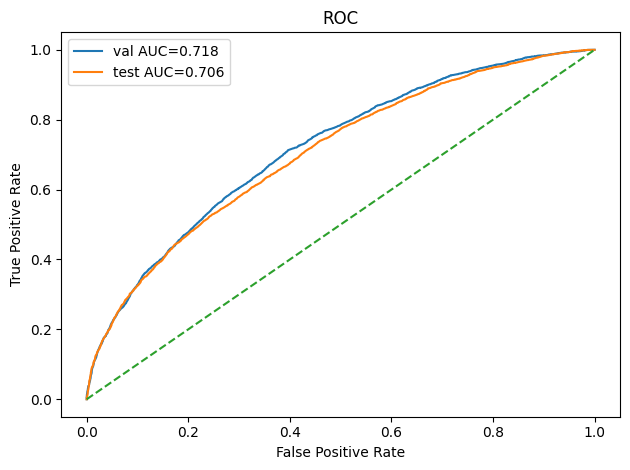

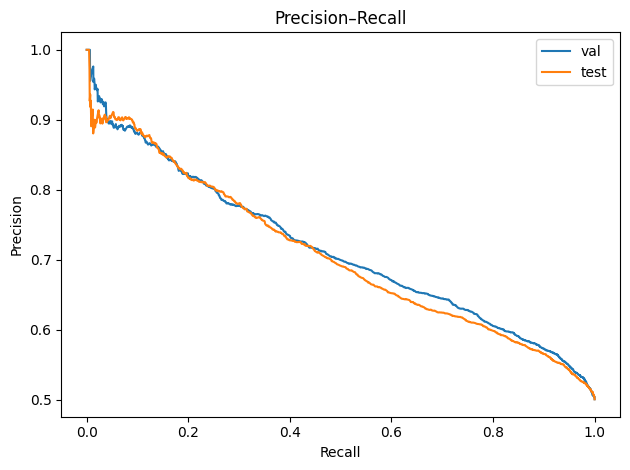

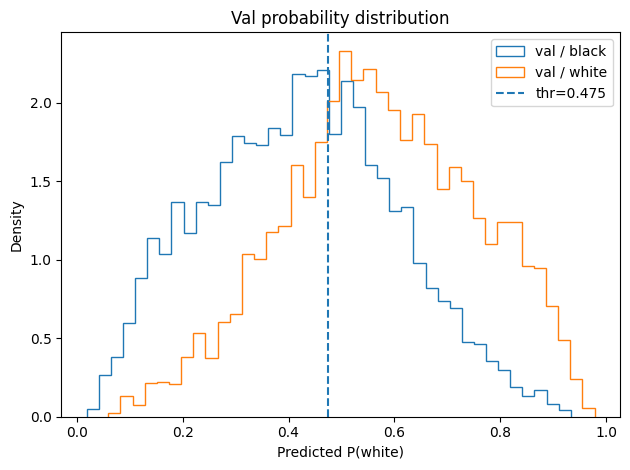

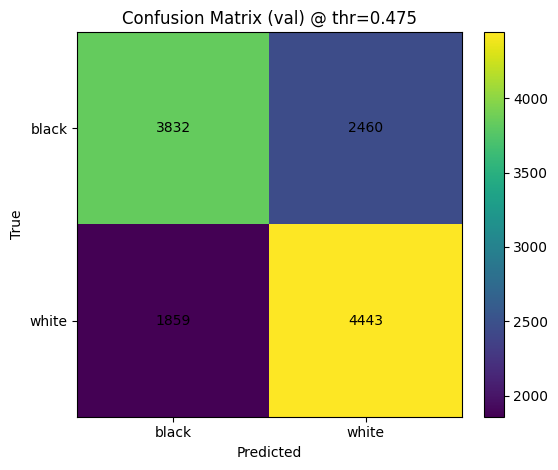

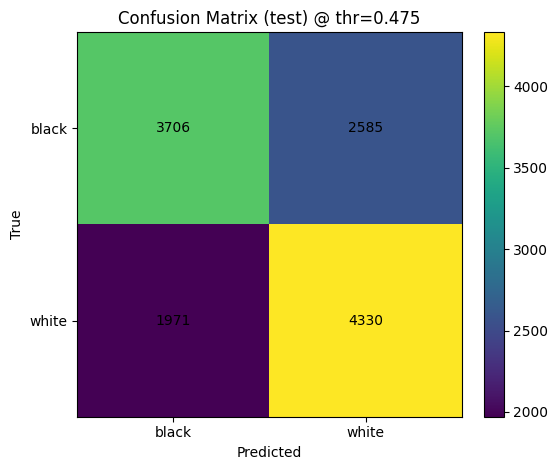

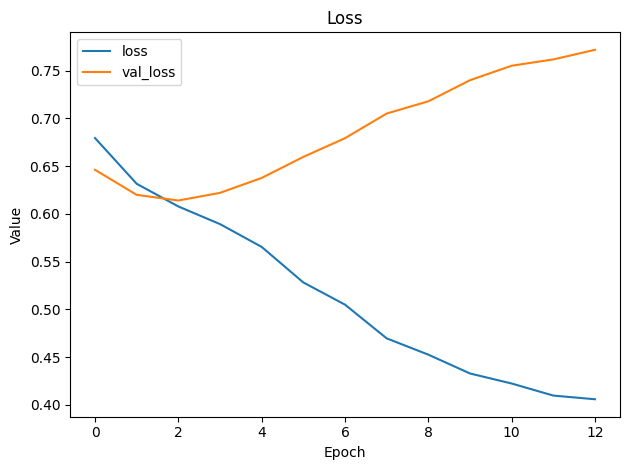

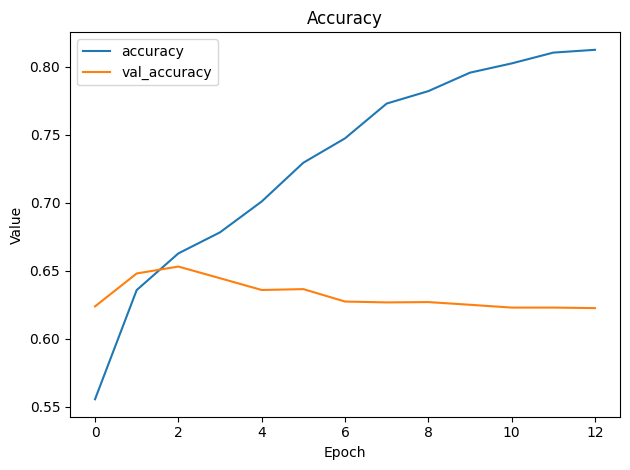

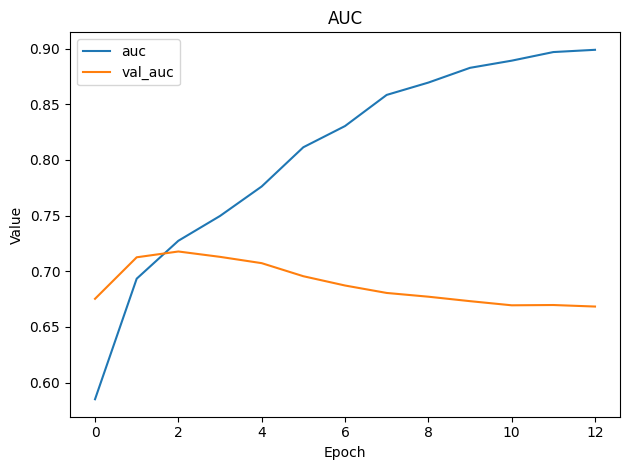

Saved plots and summary to: /content/drive/MyDrive/chess-outcome-prediction/results


In [ ]:
# ============================================================
# 4 · Final Evaluation & Plots (val + test)
# ============================================================
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

RESULTS_DIR = globals().get("RESULTS_DIR", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# -------------------------
# 4.1 Predict probabilities
# -------------------------
val_prob  = model.predict(ds_val,  verbose=0).ravel()
test_prob = model.predict(ds_test, verbose=0).ravel()

# -------------------------
# 4.2 Pick threshold (by val accuracy; also show best by F1)
# -------------------------
def best_thr(y_true, prob, metric="acc"):
    grid = np.linspace(0.05, 0.95, 181)  # step=0.005
    best_t, best_s = 0.5, -1.0
    for t in grid:
        y_hat = (prob >= t).astype("int32")
        s = accuracy_score(y_true, y_hat) if metric=="acc" else f1_score(y_true, y_hat, average="macro")
        if s > best_s:
            best_t, best_s = t, s
    return float(best_t), float(best_s)

best_t_acc, best_acc = best_thr(y_val, val_prob, "acc")
best_t_f1,  best_f1  = best_thr(y_val, val_prob, "f1")

THR = best_t_acc  # use accuracy-optimal threshold for reports

# -------------------------
# 4.3 Reports & confusion matrices
# -------------------------
def eval_at(y_true, prob, name, thr):
    y_pred = (prob >= thr).astype("int32")
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    rep = classification_report(y_true, y_pred, target_names=CLASS_ORDER, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred)
    print(f"[{name}] thr={thr:.3f}  acc={acc:.4f}  f1_macro={f1m:.4f}")
    print(rep)
    return acc, f1m, cm, y_pred

val_acc,  val_f1,  val_cm,  val_pred  = eval_at(y_val,  val_prob,  "val",  THR)
test_acc, test_f1, test_cm, test_pred = eval_at(y_test, test_prob, "test", THR)
print(f"Best thr by acc: {best_t_acc:.3f} (val acc={best_acc:.4f}) | by F1: {best_t_f1:.3f} (val f1={best_f1:.4f})")

# -------------------------
# 4.4 Plots (saved to results/)
# -------------------------
def plot_roc_pr():
    # ROC
    fpr_v, tpr_v, _ = roc_curve(y_val,  val_prob)
    fpr_t, tpr_t, _ = roc_curve(y_test, test_prob)
    auc_v, auc_t = auc(fpr_v, tpr_v), auc(fpr_t, tpr_t)

    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"val AUC={auc_v:.3f}")
    plt.plot(fpr_t, tpr_t, label=f"test AUC={auc_t:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "roc.png"), dpi=160)
    plt.show()

    # PR
    p_v, r_v, _ = precision_recall_curve(y_val,  val_prob)
    p_t, r_t, _ = precision_recall_curve(y_test, test_prob)
    plt.figure()
    plt.plot(r_v, p_v, label="val")
    plt.plot(r_t, p_t, label="test")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "pr.png"), dpi=160)
    plt.show()

def plot_prob_hists():
    plt.figure()
    plt.hist(val_prob[y_val==0], bins=40, density=True, histtype="step", label="val / black")
    plt.hist(val_prob[y_val==1], bins=40, density=True, histtype="step", label="val / white")
    plt.axvline(THR, linestyle="--", label=f"thr={THR:.3f}")
    plt.xlabel("Predicted P(white)"); plt.ylabel("Density"); plt.title("Val probability distribution")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "val_prob_hist.png"), dpi=160)
    plt.show()

def plot_cm(cm, title, fname):
    plt.figure()
    im = plt.imshow(cm, aspect="equal")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(CLASS_ORDER))
    plt.xticks(ticks, CLASS_ORDER); plt.yticks(ticks, CLASS_ORDER)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=160)
    plt.show()

plot_roc_pr()
plot_prob_hists()
plot_cm(val_cm,  f"Confusion Matrix (val) @ thr={THR:.3f}",  "cm_val.png")
plot_cm(test_cm, f"Confusion Matrix (test) @ thr={THR:.3f}", "cm_test.png")

# -------------------------
# 4.5 Training curves (if available)
# -------------------------
if "history" in globals():
    H = history.history
    def curve(keys, title, fname):
        keys = [k for k in keys if k in H]
        if not keys: return
        plt.figure()
        for k in keys: plt.plot(H[k], label=k)
        plt.xlabel("Epoch"); plt.ylabel("Value"); plt.title(title)
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=160)
        plt.show()

    curve(["loss","val_loss"], "Loss", "loss_curves.png")
    curve(["accuracy","val_accuracy"], "Accuracy", "acc_curves.png")
    curve(["auc","val_auc"], "AUC", "auc_curves.png")

# -------------------------
# 4.6 Persist summary
# -------------------------
summary = {
    "threshold": THR,
    "val":  {"acc": val_acc,  "f1_macro": val_f1,  "cm": val_cm.tolist()},
    "test": {"acc": test_acc, "f1_macro": test_f1, "cm": test_cm.tolist()},
    "best_thr_by_acc": {"thr": best_t_acc, "val_acc": best_acc},
    "best_thr_by_f1":  {"thr": best_t_f1,  "val_f1":  best_f1},
}
with open(os.path.join(RESULTS_DIR, "final_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved plots and summary to:", RESULTS_DIR)